In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Lecture 04

## Implementation of Neural Network
- One hidden layer
- Tanh Activation
- Moons dataset


## 1. Import Statements

In [2]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Changes-----------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Changes-----------------------------------

%matplotlib inline

## 2. Setup Global Parameters

In [3]:
###----------------
### Some parameters
###----------------

# Directory locations
inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 10000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## 3. Generate Data Set
<div style="font-family: Arial; font-size:1.2em;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [4]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X.shape, y.shape

((1000, 2), (1000,))

## 4. Visualization
<p style="font-family: Arial; font-size:1.2em;">
DataFrames are easier to visualize


In [5]:
data_df = pd.DataFrame(X, columns=['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


### 4.1 Different ways of plotting data

<Axes: xlabel='A', ylabel='B'>

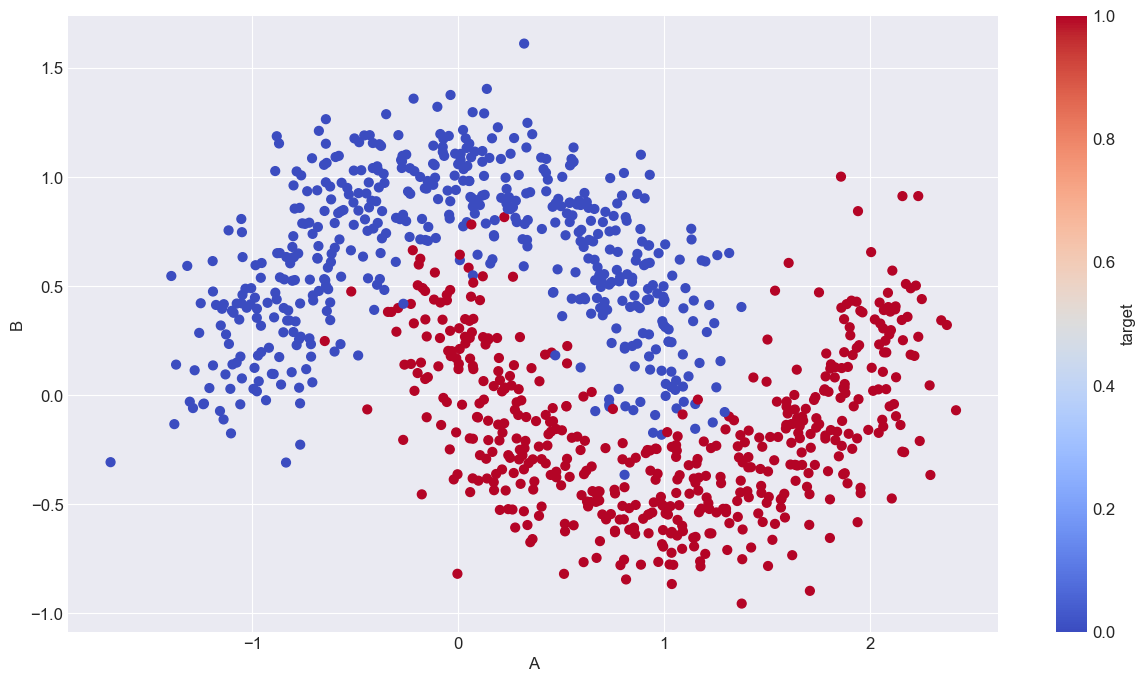

In [6]:
data_df.plot.scatter('A', 'B', s=40, c = 'target', cmap = CMAP)

<div style="font-family: Arial; font-size:1.2em;">
    We will keep 10%, i.e. 100 records for testing and remaining records will be used in training. Note that the data is already random.
</div>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

# Over to Perceptron

<div style="font-family: Arial; font-size:1.1em;">

Our output is binary. To keep the code in line with what we discussed in the lecture, we will simply output 1 for positive values of 'z' and zero for negative values.
</div>

<img src="../../images/dnn_nb_s04_fig1.png" width='500' align = 'left'>
<img src="../../images/dnn_nb_s04_fig2.png" width='500' align = 'center'>

<h4>Since there are 2 input nodes connected to 4 hidden layer perceptron since each input node is connected to every hidden layer node with means the w1 would be matrix of size(2X4) </h4>


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 5. Prediction

In [9]:
nn_input_dim = X_train.shape[1]
nn_hdim = 4
nn_output_dim = 1

hist = {}
nn_input_dim, nn_hdim, nn_output_dim

(2, 4, 1)

In [10]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(input_dim, nn_hdim)
        self.layer2 = nn.Linear(nn_hdim, nn_output_dim)

    def forward(self, x):
        x = F.tanh(self.layer1(x))  # layer 1
        x = F.sigmoid(self.layer2(x))
        return x

In [11]:
model = Model(X_train.shape[1]).to(device)
print(model)

Model(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)


In [12]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.5864,  0.1602],
         [ 0.1170,  0.2985],
         [-0.1666, -0.2828],
         [ 0.5794, -0.5647]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0931,  0.5896,  0.6636, -0.5009], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.1628, -0.1145, -0.4585,  0.4348]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.4241], device='cuda:0', requires_grad=True)]

In [13]:
print(f" Number of parameters {len(list(model.parameters()))}")

 Number of parameters 4


In [14]:
print(f" Layer 1 Weights {(list(model.parameters())[0].shape)}")
print(f" Layer 1 Bias    {(list(model.parameters())[1].shape)}")
print(f" Layer 2 Weights {(list(model.parameters())[2].shape)}")
print(f" Layer 2 Bias    {(list(model.parameters())[3].shape)}")

 Layer 1 Weights torch.Size([4, 2])
 Layer 1 Bias    torch.Size([4])
 Layer 2 Weights torch.Size([1, 4])
 Layer 2 Bias    torch.Size([1])


In [15]:
train_X = Variable(torch.Tensor(X_train)).to(device)
train_y = Variable(torch.Tensor(y_train)).to(device)
test_X = Variable(torch.Tensor(X_test)).to(device)
test_y = Variable(torch.Tensor(y_test)).to(device)
train_X.shape, test_X.shape ,train_y.shape, test_y.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [16]:
loss_fn = nn.BCEWithLogitsLoss()

trloss = []
tloss = []
n_epoch = []
acc = []
tacc = []

optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)  # optimizer


# Iteration

for epoch in range(EPOCHS):
    ### Training
    model.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model(train_X).squeeze()  # squeeze to remove extra `1` dimensions,
    # this won't work unless model and data are on same device
    y_pred = torch.round(y_logits)

    # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy

    loss = loss_fn(y_logits, train_y)  # Using nn.BCEWithLogitsLoss works with raw logit
    accuracy = accuracy_score(train_y.cpu(), y_pred.data.cpu())

    trloss.append(loss.data.item())
    acc.append(accuracy)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass

        test_logits = model(test_X).squeeze()
        test_pred = torch.round(test_logits)

        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, test_y)
        test_acc = accuracy_score(test_y.cpu(), test_pred.data.cpu())

        tloss.append(test_loss.data.item())
        tacc.append(test_acc)
        n_epoch.append(epoch)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss.data.item():.5f}, Accuracy: {accuracy:.2f}% | Test loss: {test_loss.data.item():.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.69077, Accuracy: 0.50% | Test loss: 0.67555, Test acc: 0.50%
Epoch: 100 | Loss: 0.56180, Accuracy: 0.87% | Test loss: 0.56606, Test acc: 0.84%
Epoch: 200 | Loss: 0.56117, Accuracy: 0.87% | Test loss: 0.56549, Test acc: 0.84%
Epoch: 300 | Loss: 0.54725, Accuracy: 0.91% | Test loss: 0.54204, Test acc: 0.92%
Epoch: 400 | Loss: 0.51430, Accuracy: 0.98% | Test loss: 0.52124, Test acc: 0.95%
Epoch: 500 | Loss: 0.51321, Accuracy: 0.98% | Test loss: 0.52090, Test acc: 0.95%
Epoch: 600 | Loss: 0.51273, Accuracy: 0.98% | Test loss: 0.52078, Test acc: 0.95%
Epoch: 700 | Loss: 0.51243, Accuracy: 0.98% | Test loss: 0.52068, Test acc: 0.96%
Epoch: 800 | Loss: 0.51222, Accuracy: 0.98% | Test loss: 0.52060, Test acc: 0.96%
Epoch: 900 | Loss: 0.51204, Accuracy: 0.98% | Test loss: 0.52051, Test acc: 0.96%
Epoch: 1000 | Loss: 0.51190, Accuracy: 0.98% | Test loss: 0.52043, Test acc: 0.96%
Epoch: 1100 | Loss: 0.51176, Accuracy: 0.98% | Test loss: 0.52034, Test acc: 0.96%
Epoch: 1200 | Lo

In [25]:
list(model.parameters())

[Parameter containing:
 tensor([[ 35.0301, -11.1091],
         [ -8.0262,  11.9193],
         [ -5.5130,   1.9089],
         [ -4.9088,  -5.3415]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([16.7124, -6.4144,  6.4487,  3.8300], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[ 24.4978, -10.4979, -71.6397,  83.8327]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-5.1070], device='cuda:0', requires_grad=True)]

In [26]:
loss_df = pd.DataFrame(
    {"epoch": n_epoch, "loss": trloss, "test loss": tloss, "acc": acc, "test acc": tacc}
)
loss_df.head()

,epoch,loss,test loss,acc,test acc
0,0,0.690773,0.675546,0.50000,0.500
1,1,0.676470,0.662870,0.50000,0.500
2,2,0.664154,0.649430,0.50000,0.605
3,3,0.651074,0.634524,0.63375,0.775
4,4,0.636678,0.620441,0.77125,0.815


<Axes: xlabel='epoch'>

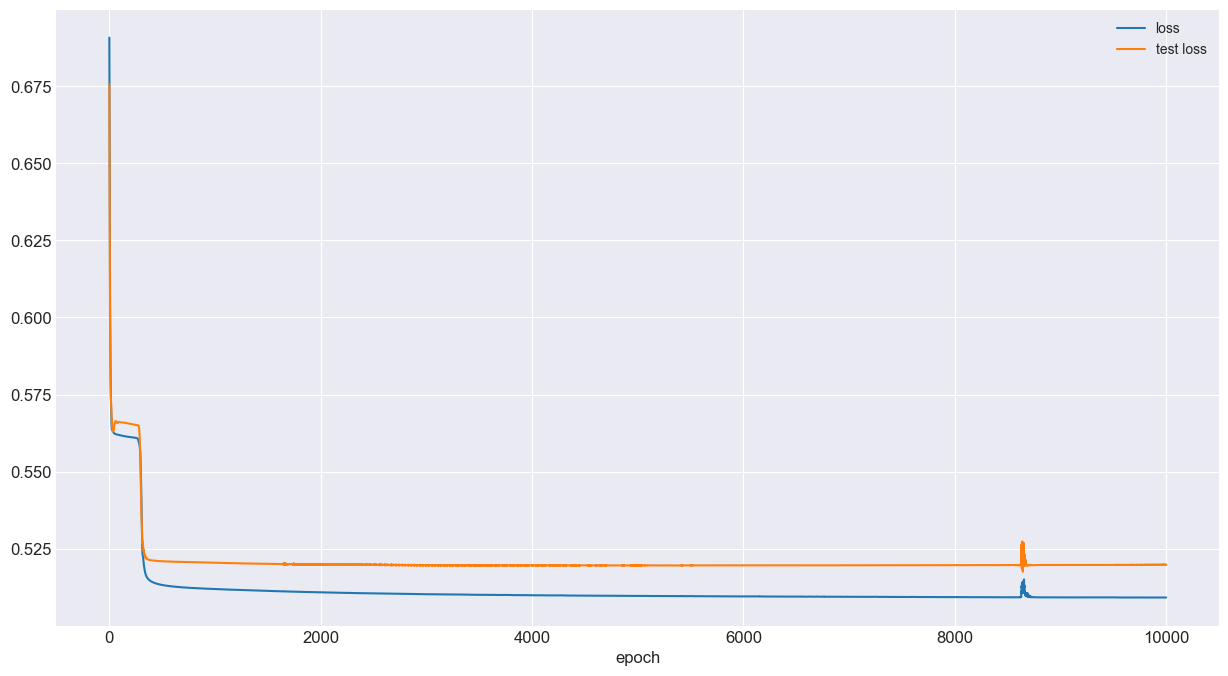

In [27]:
loss_df.plot(x="epoch", y=["loss", "test loss"])

<Axes: xlabel='epoch'>

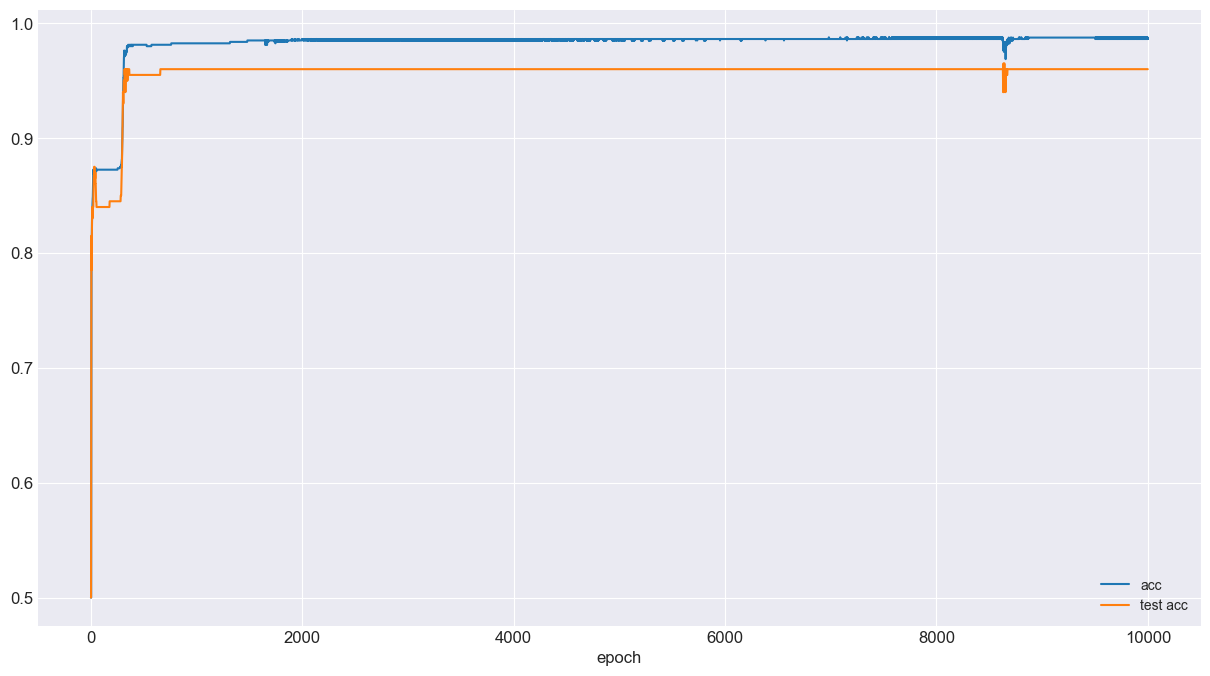

In [28]:
loss_df.plot(x="epoch", y=["acc", "test acc"])

In [29]:
test_logits = model(test_X).squeeze()
test_pred = torch.round(test_logits)

# 2. Caculate loss/accuracy
test_loss = loss_fn(test_logits, test_y)
test_acc = accuracy_score(test_y.cpu(), test_pred.data.cpu())


print(f"Accuracy score on Test Data : {test_acc: .4f}")

Accuracy score on Test Data :  0.9600


In [30]:
cm = confusion_matrix(test_y.cpu(), test_pred.data.cpu())
cm

array([[99,  1],
       [ 7, 93]], dtype=int64)

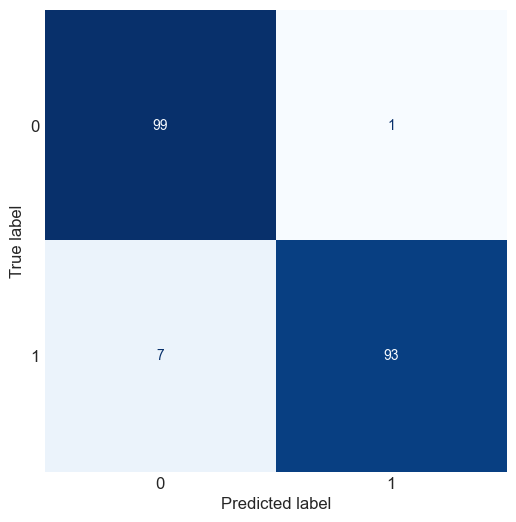

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(ax=ax, cmap="Blues", colorbar=False)

plt.grid()